### Calculate condition specificity, annotate cluster size

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import time
import sys
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import ListedColormap
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom, pearsonr
from scipy import stats
import random
import matplotlib as mpl

import matplotlib.cm as cm
import matplotlib.colors as mcolors 

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 150)
#sc.set_figure_params(figsize=(20, 4))
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)

In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad', backed='r')
adata_de_obs = adata_de.obs.copy()
# masked_zscore_df = pd.DataFrame(adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].layers['masked_zscore'],
#                                 index=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].obs_names,
#                                 columns=adata_de[adata_de.obs.target_contrast_corrected.isin(adata_final.obs.target_contrast_corrected.unique().tolist())].var_names)

# X = masked_zscore_df.values
# row_means = X.mean(axis=1, keepdims=True)
# row_stds = X.std(axis=1, keepdims=True)
# Z = (X - row_means) / row_stds
# R_unscaled = Z @ Z.T
# R = R_unscaled / (X.shape[1])
# corr_df_all = pd.DataFrame(R, index=masked_zscore_df.index.tolist(), columns=masked_zscore_df.index.tolist())
# corr_df_all.to_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv')
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
downstream_gene_df = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
# cluster_nde75_ntotal50 = adata_final.obs.copy()
# cluster_nde75_ntotal50.to_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv')
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)

### Calculate the correlation mean of rest, stim8hr, stim48hr for each cluster

In [4]:
def corr_compute(df):
    X = df.values
    row_means = X.mean(axis=1, keepdims=True)
    row_stds = X.std(axis=1, keepdims=True)
    Z = (X - row_means) / row_stds
    R_unscaled = Z @ Z.T
    R = R_unscaled / (X.shape[1])
    corr_df = pd.DataFrame(R, index=df.index.tolist(), columns=df.index.tolist())
    return corr_df

def corr_mean_by_condition(df):
    df = df.reset_index()
    df = df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    return np.mean(corr_rest), np.mean(corr_stim8hr), np.mean(corr_stim48hr)

In [61]:
cluster_df = pd.DataFrame(cluster_nde75_ntotal50[['target_contrast_corrected',
                                                  'hdbscan']].drop_duplicates()['hdbscan'].value_counts())
cluster_df.columns = ['cluster_gene_size']
cluster_df['corr_rest'] = 0
cluster_df['corr_stim8hr'] = 0
cluster_df['corr_stim48hr'] = 0

In [62]:
for cl in cluster_df.index.unique():
    gene_id_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected']
    obs_names = adata_de_obs[adata_de_obs['target_contrast_corrected'].isin(gene_id_list)].index
    corr_df = corr_df_all.loc[obs_names,obs_names].copy()
    corr_df = corr_df.reset_index()
    corr_df = corr_df.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_df, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]
    
    corr_all_long['Canonical_Pair'] = corr_all_long.apply(
        lambda row: tuple(sorted([row['Index_ID'], row['Column_ID']])),
        axis=1
    )
    corr_all_long = corr_all_long.drop_duplicates(subset=['Canonical_Pair'], keep='first')
    corr_all_long = corr_all_long.drop(columns=['Canonical_Pair'])
    
    corr_rest = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value
    corr_stim8hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value
    corr_stim48hr = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value

    cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
    cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
    cluster_df.loc[cl, 'corr_stim48hr'] = np.mean(corr_stim48hr)

cluster_df['corr_max'] = cluster_df.iloc[:,1:4].max(1)
cluster_df['corr_std'] = cluster_df.iloc[:,1:4].std(1) 
cluster_df['corr_cov'] = cluster_df.iloc[:,1:4].std(1) / cluster_df.iloc[:,1:4].mean(1)
cluster_df['corr_min'] = cluster_df.iloc[:,1:4].min(1)
cluster_df['corr_mean'] = cluster_df.iloc[:,1:4].mean(1)
cluster_df.sort_index(axis=0, ascending=True, inplace=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_32793/4244043763.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03171675341206319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_rest'] = np.mean(corr_rest)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_32793/4244043763.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.026276039328289806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cl, 'corr_stim8hr'] = np.mean(corr_stim8hr)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_32793/4244043763.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03128375786860269' has dtype 

### Classify clusters

In [69]:
corr_cov_thres = 0.5

In [70]:
cluster_df.loc[cluster_df.corr_cov<=corr_cov_thres,'condition_specificity'] = 'across_condition'

In [71]:
corr_fc_thres = 1.2
corr_thres = 0.2

def get_condition_specificity(row):
    # Calculate ratios
    r_rest = row['corr_rest'] / row['corr_mean']
    r_stim8hr = row['corr_stim8hr'] / row['corr_mean']
    r_stim48hr = row['corr_stim48hr'] / row['corr_mean']
    
    # Check pairs first (priority over singles)
    if ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)):
        return 'Rest_Stim8hr'
    elif ((r_rest>corr_fc_thres) or (row['corr_rest']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Rest_Stim48hr'
    elif ((r_stim8hr>corr_fc_thres) or (row['corr_stim8hr']>corr_thres)) and ((r_stim48hr>corr_fc_thres) or (row['corr_stim48hr']>corr_thres)):
        return 'Stim8hr_Stim48hr'
        
    # Check singles
    elif r_rest > corr_fc_thres:
        return 'Rest'
    elif r_stim8hr > corr_fc_thres:
        return 'Stim8hr'
    elif r_stim48hr > corr_fc_thres:
        return 'Stim48hr'
        
    # Fallback (if no condition met)
    return 'across_condition'

# 1. Filter for high covariance
mask_cov = cluster_df['corr_cov'] > 0.5
filtered_df = cluster_df[mask_cov].copy()

# 2. Apply logic only to filtered rows
filtered_df['condition_specificity'] = filtered_df.apply(get_condition_specificity, axis=1)

# Update original dataframe
cluster_df.update(filtered_df)

In [74]:
cluster_df.to_csv('./results/nde75ntotal50_cluster_specificity.csv')

In [2]:
cluster_df = pd.read_csv('./results/nde75ntotal50_cluster_specificity.csv')

In [3]:
cluster_df

,hdbscan,cluster_gene_size,corr_rest,corr_stim8hr,corr_stim48hr,corr_max,corr_std,corr_cov,corr_min,corr_mean,condition_specificity
0,-1,405,0.031717,0.026276,0.031284,0.031717,0.003024,0.101616,0.026276,0.029759,across_condition
1,0,7,0.406482,0.512976,0.496743,0.512976,0.057376,0.121541,0.406482,0.472067,across_condition
2,1,2,0.382711,0.411564,0.292067,0.411564,0.062354,0.172195,0.292067,0.362114,across_condition
3,2,11,0.261680,0.304254,0.281659,0.304254,0.021300,0.075390,0.261680,0.282531,across_condition
4,3,3,0.508555,0.503570,0.453038,0.508555,0.030715,0.062891,0.453038,0.488388,across_condition
5,4,2,0.494691,0.518754,0.535180,0.535180,0.020364,0.039450,0.494691,0.516208,across_condition
6,5,2,0.583847,0.596078,0.595940,0.596078,0.007022,0.011862,0.583847,0.591955,across_condition
7,6,6,0.281898,0.284300,0.202250,0.284300,0.046693,0.182289,0.202250,0.256149,across_condition
8,7,10,0.375615,0.412734,0.250229,0.412734,0.085154,0.245973,0.250229,0.346192,across_condition
9,8,7,0.287590,0.344533,0.272032,0.344533,0.038169,0.126644,0.272032,0.301385,across_condition


### Plot selective clusters

In [15]:
mask = ((cluster_df.cluster_gene_size>=55)&(cluster_df.corr_max>0.2))|\
((cluster_df.cluster_gene_size<55)&(cluster_df.cluster_gene_size>6)&(cluster_df.corr_max>0.3))|\
((cluster_df.cluster_gene_size==4)&(cluster_df.corr_max>0.375))|\
((cluster_df.cluster_gene_size==6)&(cluster_df.corr_max>0.32))
condition_specificity = cluster_df[mask].copy()
condition_specificity = condition_specificity.sort_index()

In [ ]:
condition_specificity.sort_values(by='corr_cov', ascending=False)

In [ ]:
thres = 0.4
fig, ax = plt.subplots(figsize=(11, 1.2))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(condition_specificity.loc[cluster_order, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, 
            yticklabels=['Rest', 'Stim8hr', 'Stim48hr'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_withlabel.pdf', dpi=600)

In [19]:
cluster_order = [106, 27, 105, 101, 84, 104, 30, 60,
                 21, 22, 99, 93, 
                 103, 36, 77, 107, 102, 111,
                 7, 62,
                 98, 46, 91, 33, 108, 61, 31, 32, 15, 28, 58,
                 68, 48, 74, 38,
                 34, 8, 2, 83, 9, 10, 0, 65, 66, 81]

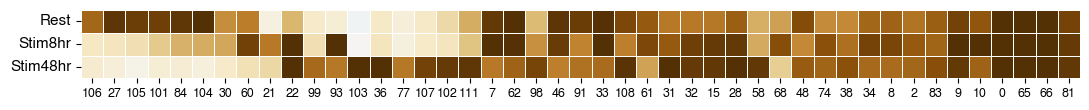

In [41]:
thres = 0.4
fig, ax = plt.subplots(figsize=(11, 1.2))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(condition_specificity.loc[cluster_order, ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=['Rest', 'Stim8hr', 'Stim48hr'])
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
ax.set_xticklabels(cluster_order, fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_withlabel.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

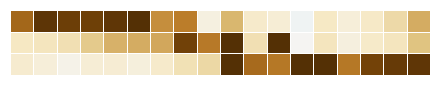

In [39]:
thres = 0.4
fig, ax = plt.subplots(figsize=(4.5, 0.95))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(condition_specificity.loc[cluster_order[:18], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
#ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
#ax.set_xticklabels(cluster_order[:18], fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_nolabel_condspec.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

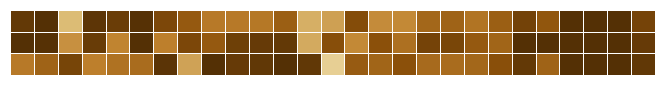

In [40]:
thres = 0.4
fig, ax = plt.subplots(figsize=(6.75, 0.95))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(condition_specificity.loc[cluster_order[18:], ['corr_rest', 'corr_stim8hr', 'corr_stim48hr']].T, vmin=-thres, vmax=thres, ax=ax,
            linewidth=0.5, cmap='BrBG_r', cbar=False, yticklabels=False, xticklabels=False)
#ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], fontsize=11, rotation=0)
#ax.set_xticklabels(cluster_order[:18], fontsize=9, rotation=0)
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./results/condition_specificity_nolabel_condacross.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

## TCR cluster downstream gene cluster 21+22 vs cluster 99

In [7]:
downstream_gene_df = pd.DataFrame()
# Stim8hr clusters
adata_subset = adata_de[adata_de.obs_names.isin(adata_final[adata_final.obs.hdbscan.isin([21,22])].obs_names)].to_memory().copy()
# First only consider DE gene for at least one cluster member regulator
adata_subset = adata_subset[:,(adata_subset.layers['adj_p_value']<0.1).sum(0)>=1].copy()
downstream_gene_list = adata_subset.var['gene_name'].tolist()
downstream_gene_ids_list = adata_subset.var['gene_ids'].tolist()
# Calculate simple number of upstream regulators for each gene
num_of_upstream = (adata_subset.layers['adj_p_value']<0.1).sum(0)
sign_coherence = ((adata_subset.layers['adj_p_value']<0.1) * (np.sign(adata_subset.layers['zscore']))).sum(0) / num_of_upstream
# For each member regulator, calculate the rank of downstream genes based on zscore, then add the rank together and rank based on sum rank
zscore_rank_neg = stats.rankdata(stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
zscore_rank_pos = stats.rankdata(-stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
# Summarize into dataFrame
df = pd.DataFrame({'hdbscan_cluster': 'early',
                   'downstream_gene': downstream_gene_list,
                   'downstream_gene_ids': downstream_gene_ids_list,
                   'num_of_upstream': num_of_upstream,
                   'sign_coherence': sign_coherence,
                   'zscore_rank_negative_regulation': zscore_rank_neg,
                   'zscore_rank_positive_regulation': zscore_rank_pos,})
downstream_gene_df = pd.concat([downstream_gene_df, df])

# Stim48hr clusters
adata_subset = adata_de[adata_de.obs_names.isin(adata_final[adata_final.obs.hdbscan.isin([99])].obs_names)].to_memory().copy()
# First only consider DE gene for at least one cluster member regulator
adata_subset = adata_subset[:,(adata_subset.layers['adj_p_value']<0.1).sum(0)>=1].copy()
downstream_gene_list = adata_subset.var['gene_name'].tolist()
downstream_gene_ids_list = adata_subset.var['gene_ids'].tolist()
# Calculate simple number of upstream regulators for each gene
num_of_upstream = (adata_subset.layers['adj_p_value']<0.1).sum(0)
sign_coherence = ((adata_subset.layers['adj_p_value']<0.1) * (np.sign(adata_subset.layers['zscore']))).sum(0) / num_of_upstream
# For each member regulator, calculate the rank of downstream genes based on zscore, then add the rank together and rank based on sum rank
zscore_rank_neg = stats.rankdata(stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
zscore_rank_pos = stats.rankdata(-stats.rankdata(adata_subset.layers['zscore'], axis=1).sum(0)).astype(int)
# Summarize into dataFrame
df = pd.DataFrame({'hdbscan_cluster': 'late',
                   'downstream_gene': downstream_gene_list,
                   'downstream_gene_ids': downstream_gene_ids_list,
                   'num_of_upstream': num_of_upstream,
                   'sign_coherence': sign_coherence,
                   'zscore_rank_negative_regulation': zscore_rank_neg,
                   'zscore_rank_positive_regulation': zscore_rank_pos,})

downstream_gene_df = pd.concat([downstream_gene_df, df])

In [119]:
common_gene = pd.DataFrame(list(set(downstream_gene_df[downstream_gene_df.hdbscan_cluster=='early'].downstream_gene.tolist())\
                             & set(downstream_gene_df[downstream_gene_df.hdbscan_cluster=='late'].downstream_gene.tolist())),
                       columns=['gene'])
rank1 = np.array(downstream_gene_df[downstream_gene_df.hdbscan_cluster=='early'].set_index('downstream_gene').loc[common_gene.gene, 'zscore_rank_negative_regulation'])
rank2 = np.array(downstream_gene_df[downstream_gene_df.hdbscan_cluster=='late'].set_index('downstream_gene').loc[common_gene.gene, 'zscore_rank_negative_regulation'])
rank1_norm = 1 - (rank1 - np.min(rank1)) / np.max(rank1)
rank2_norm = 1 - (rank2 - np.min(rank2)) / np.max(rank2)

In [227]:
df_rank = pd.DataFrame({'Gene': common_gene['gene'].tolist(), 'rank_norm_stim8hr': rank1_norm, 'rank_norm_stim48hr': rank2_norm})
df_rank['rank_diff'] = df_rank['rank_norm_stim8hr'] - df_rank['rank_norm_stim48hr']
df_rank['log_rank_diff'] = np.log(df_rank['rank_norm_stim8hr']) - np.log(df_rank['rank_norm_stim48hr'])

In [250]:
df_rank[df_rank.Gene=='IL2RA']

,Gene,rank_norm_stim8hr,rank_norm_stim48hr,rank_diff,log_rank_diff
5861,IL2RA,0.825286,0.225848,0.599438,1.295869


### Check GO enrichment of genes enriched in early cluster (21+22) or late cluster (99)

In [281]:
import gseapy as gp

go_bp_sets = gp.get_library(name='GO_Biological_Process_2023', organism='Human')
go_cc_sets = gp.get_library(name='GO_Cellular_Component_2023', organism='Human')

In [315]:
# Check top 25% genes that are positively regulated by early or late cluster with ranking difference of at least 30%
top_thres = 0.8
rank_diff = 0.4
padj_thres = 0.05
log_rank_diff = 0.7

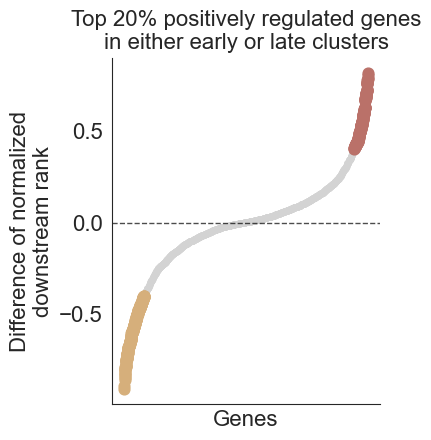

In [408]:
# Sort the DataFrame by rank_diff
# Reset index so we can use the new index as the x-axis (Rank Position)
mask = (df_rank['rank_norm_stim8hr']>0.8) | (df_rank['rank_norm_stim48hr']>0.8) # Choose only top 20% positively regulated genes
df_sorted = df_rank[mask].sort_values('rank_diff').reset_index(drop=True)

# Identify which rows match our canonical list
# We create a boolean mask or filter specifically for the highlights
early_df = df_sorted[df_sorted['rank_diff']>0.4]
late_df = df_sorted[df_sorted['rank_diff']<-0.4]

# Setup the Plot
fig, ax = plt.subplots(figsize=(4, 4.5))
sns.set_style("white")

# Plot the background (all genes)
# We use the index for X (Rank) and rank_diff for Y
ax.scatter(df_sorted.index, df_sorted['rank_diff'], 
            c='lightgrey', s=15, alpha=0.5, rasterized=True)

# Plot the early downstream genes
ax.scatter(early_df.index, early_df['rank_diff'], 
            c='#ba7169', s=60, rasterized=True)

# Plot the late downstream genes
ax.scatter(late_df.index, late_df['rank_diff'], 
            c='#d6af7b', s=60, rasterized=True)

# Formatting
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xticks([])
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Difference of normalized\ndownstream rank', fontsize=16)
ax.set_title('Top 20% positively regulated genes\nin either early or late clusters', fontsize=16)

sns.despine()

plt.tight_layout()
plt.savefig('./results/early_vs_late_normalized_rank_diff.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [413]:
def wrap_long_label_at_middle_space(label, max_length=40):
    """
    Wraps a long label by inserting a newline (\n) at the space closest to the middle.
    """
    if len(label) > max_length:
        # 1. Split the label into words
        words = label.split(' ')
        num_words = len(words)

        if num_words > 1:
            # 2. Find the index for the split point (e.g., for 6 words, split after 3rd word)
            # The split index will be len(words) // 2
            split_index = num_words // 2 + 1

            # 3. Join the first half with spaces, then add a newline, and join the second half with spaces
            line1 = ' '.join(words[:split_index])
            line2 = ' '.join(words[split_index:])
            return f'{line1}\n{line2}'

    return label

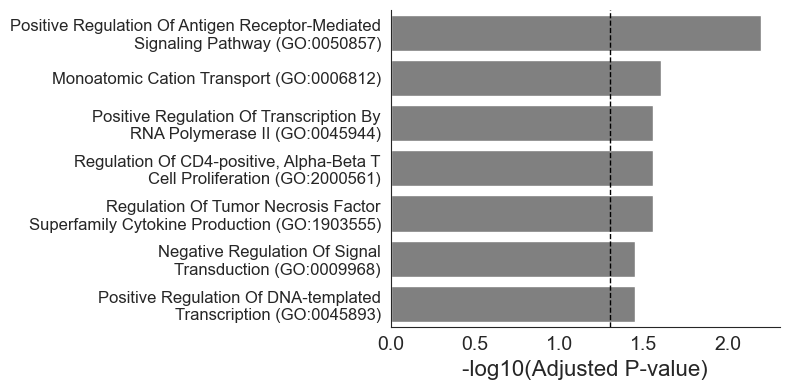

In [432]:
bg = df_rank.Gene.tolist()
enr = gp.enrichr(gene_list=df_rank[(df_rank['rank_diff']>rank_diff)&(df_rank['rank_norm_stim8hr']>top_thres)].Gene.tolist(), 
                gene_sets=[go_bp_sets],# go_cc_sets],
                organism='human',
                outdir=None,
                background=bg
                )
df = enr.results.copy()
df = df[df['Adjusted P-value'] < padj_thres]
df['Neglog_p'] = -np.log10(df['Adjusted P-value'])

# Remove terms that are duplicated
term_remove = ['Metal Ion Transport (GO:0030001)']
df = df[~df['Term'].isin(term_remove)]

df['Wrapped_Term'] = df['Term'].apply(wrap_long_label_at_middle_space)

df = df.sort_values('Neglog_p', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='Neglog_p', y='Wrapped_Term', color='gray')
threshold = -np.log10(padj_thres)
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=1)
plt.xlabel('-log10(Adjusted P-value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('') # Remove y-axis label
sns.despine()
plt.tight_layout()
plt.savefig('./results/early_specific_downstream_go_enrichment.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

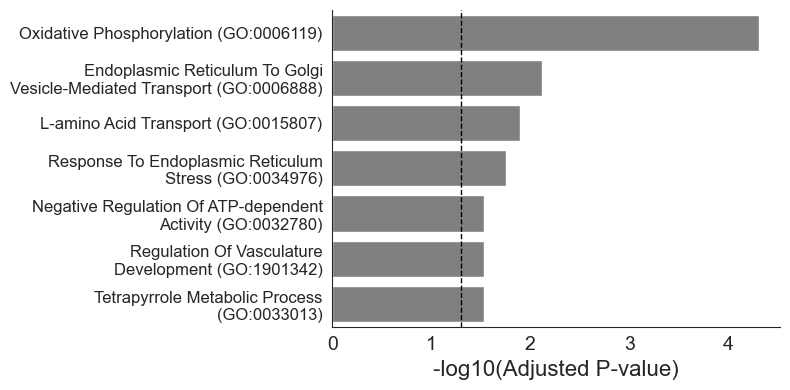

In [433]:
bg = df_rank.Gene.tolist()
enr = gp.enrichr(gene_list=df_rank[(df_rank['rank_diff']<-rank_diff)&(df_rank['rank_norm_stim48hr']>top_thres)].Gene.tolist(), 
                gene_sets=[go_bp_sets],# go_cc_sets],
                organism='human',
                outdir=None,
                background=bg
                )
df = enr.results.copy()
df = df[df['Adjusted P-value'] < padj_thres]
df['Neglog_p'] = -np.log10(df['Adjusted P-value'])

# Remove terms that are duplicated
term_remove = ['Cellular Respiration (GO:0045333)',
              'Proton Motive Force-Driven ATP Synthesis (GO:0015986)',
              'Aerobic Respiration (GO:0009060)',
              'Aerobic Electron Transport Chain (GO:0019646)',
              'Proton Motive Force-Driven Mitochondrial ATP Synthesis (GO:0042776)',
              'Mitochondrial ATP Synthesis Coupled Electron Transport (GO:0042775)',
               'Mitochondrial Electron Transport, NADH To Ubiquinone (GO:0006120)',
               'Mitochondrial Respiratory Chain Complex I Assembly (GO:0032981)',
               'NADH Dehydrogenase Complex Assembly (GO:0010257)',
               'Mitochondrial Respiratory Chain Complex Assembly (GO:0033108)',
               'Golgi Vesicle Transport (GO:0048193)',
               'L-alpha-amino Acid Transmembrane Transport (GO:1902475)',
               'Electron Transport Chain (GO:0022900)',
               'Regulation Of Transcription From RNA Polymerase II Promoter In Response To Stress (GO:0043618)',
               'Neutral Amino Acid Transport (GO:0015804)',
               'Positive Regulation Of Transcription From RNA Polymerase II Promoter In Response To Endoplasmic Reticulum Stress (GO:1990440)',
               'Intrinsic Apoptotic Signaling Pathway In Response To Endoplasmic Reticulum Stress (GO:0070059)',
               'Positive Regulation Of Cellular Senescence (GO:2000774)'
              ]
df = df[~df['Term'].isin(term_remove)]
df['Wrapped_Term'] = df['Term'].apply(wrap_long_label_at_middle_space)

df = df.sort_values('Neglog_p', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='Neglog_p', y='Wrapped_Term', color='gray')
threshold = -np.log10(padj_thres)
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=1)
plt.xlabel('-log10(Adjusted P-value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.savefig('./results/late_specific_downstream_go_enrichment.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [426]:
df.loc[711, 'Term']

'Positive Regulation Of Cellular Senescence (GO:2000774)'

In [424]:
df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Neglog_p,Wrapped_Term
656,gs_ind_0,Oxidative Phosphorylation (GO:0006119),11/55,3.426158e-08,0.000049,11.549888,198.533813,NDUFS2;NDUFC2;NDUFA5;ATP5PB;NDUFC1;UQCRC1;NDUF...,4.307736,Oxidative Phosphorylation (GO:0006119)
217,gs_ind_0,Endoplasmic Reticulum To Golgi Vesicle-Mediate...,10/96,6.428401e-05,0.007698,5.374936,51.879957,SEC24A;SEC22B;SCFD1;COPB1;KLHL12;YIPF5;TRAPPC1...,2.113621,Endoplasmic Reticulum To Golgi\nVesicle-Mediat...
353,gs_ind_0,L-amino Acid Transport (GO:0015807),4/12,1.138241e-04,0.012582,22.980893,208.686190,SLC7A11;SLC6A9;SLC38A1;SLC38A2,1.900252,L-amino Acid Transport (GO:0015807)
1274,gs_ind_0,Response To Endoplasmic Reticulum Stress (GO:0...,9/88,1.724776e-04,0.017704,5.270067,45.666412,TP53;ATF4;DDIT3;PPP1R15B;ATF3;HERPUD1;HYOU1;PP...,1.751939,Response To Endoplasmic Reticulum\nStress (GO:...
446,gs_ind_0,Negative Regulation Of ATP-dependent Activity ...,3/7,3.852531e-04,0.029453,33.620477,264.311079,TP53;PXK;SIRT1,1.530871,Negative Regulation Of ATP-dependent\nActivity...
1251,gs_ind_0,Regulation Of Vasculature Development (GO:1901...,4/16,3.894267e-04,0.029453,15.620325,122.632593,HTATIP2;WARS1;RNH1;PDCD10,1.530871,Regulation Of Vasculature\nDevelopment (GO:190...
1366,gs_ind_0,Tetrapyrrole Metabolic Process (GO:0033013),3/7,3.852531e-04,0.029453,33.620477,264.311079,MMAA;MMAB;UROD,1.530871,Tetrapyrrole Metabolic Process\n(GO:0033013)
711,gs_ind_0,Positive Regulation Of Cellular Senescence (GO...,3/8,6.060239e-04,0.043543,27.504724,203.771252,TP53;CGAS;SIRT1,1.361083,Positive Regulation Of Cellular\nSenescence (G...


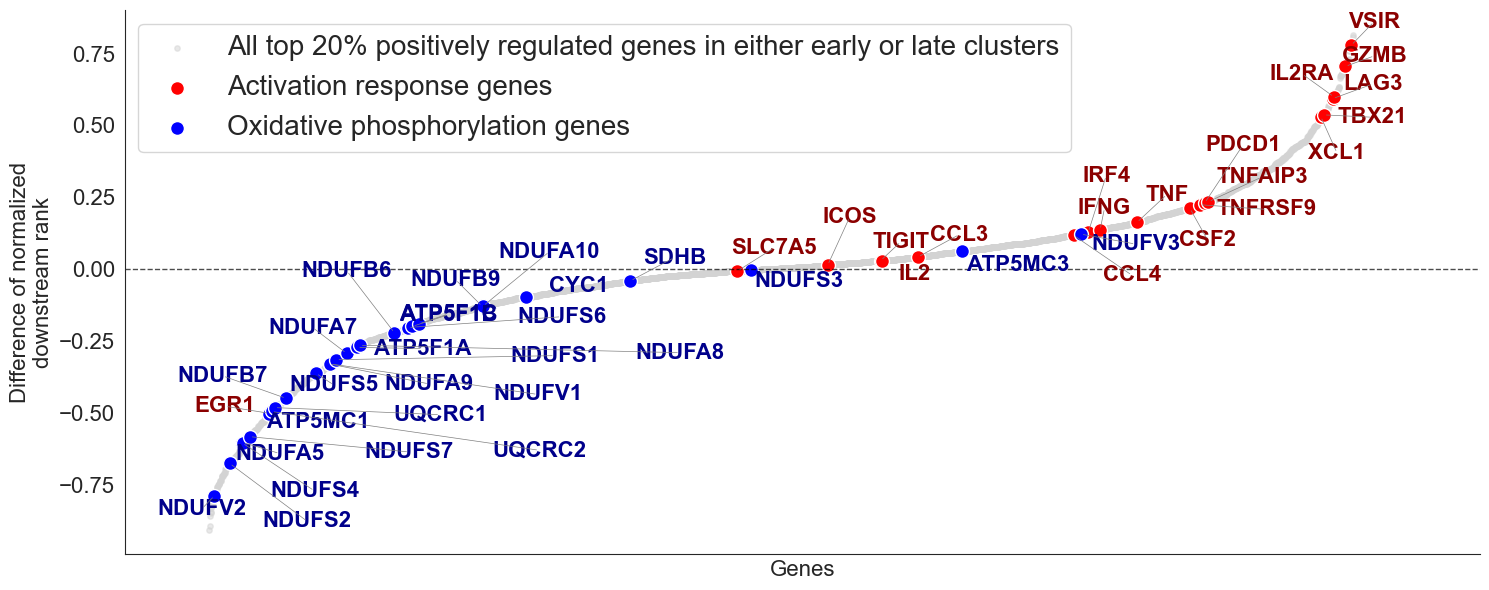

In [469]:
canonical_t_cell_genes = [
    # Immediate response genes
    'FOS', 'JUN', 'JUNB', 'EGR1', 'NR4A1', 'NFKB1',
    
    # Cytokines/Effectors
    'IL2', 'TNF', 'IFNG', 'CD69', 'CSF2', 'CCL3', 'CCL4', 'XCL1', 'GZMB', 'PRF1', 'ICAM1',
    
    # Co-stimulatory
    'IL2RA', 'CD40LG', 'ICOS', 'TNFRSF4', 'TNFRSF9', 'TNFRSF18',
    
    # Checkpoints / Feedback
    'PDCD1', 'LAG3', 'HAVCR2', 'CTLA4', 'TIGIT', 'BTLA', 'VSIR', 'TNFAIP3',
    
    # Transcription/Metabolic Regulators
    'IRF4', 'BATF', 'TBX21', 'PRDM1', 'SLC2A1', 'SLC7A5', 'MKI67'
]

canonical_oxphos_genes = [
    # Complex I: NADH:Ubiquinone Oxidoreductase
    "MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", "MT-ND4L", "MT-ND5", "MT-ND6",
    "NDUFA1", "NDUFA2", "NDUFA3", "NDUFA4", "NDUFA5", "NDUFA6", "NDUFA7", "NDUFA8", "NDUFA9", "NDUFA10", "NDUFA11", "NDUFA12", "NDUFA13",
    "NDUFB1", "NDUFB2", "NDUFB3", "NDUFB4", "NDUFB5", "NDUFB6", "NDUFB7", "NDUFB8", "NDUFB9", "NDUFB10", "NDUFB11",
    "NDUFS1", "NDUFS2", "NDUFS3", "NDUFS4", "NDUFS5", "NDUFS6", "NDUFS7", "NDUFS8",
    "NDUFV1", "NDUFV2", "NDUFV3",

    # Complex II: Succinate Dehydrogenase (SDH)
    "SDHA", "SDHB", "SDHC", "SDHD",

    # Complex III: Cytochrome bc1 Complex
    "MT-CYB",
    "UQCRC1", "UQCRC2",
    "CYC1",

    # Complex IV: Cytochrome c Oxidase (COX)
    "MT-CO1", "MT-CO2", "MT-CO3",
    "COX4I1",
    "COX5A", "COX5B",
    "COX6A1", "COX6B1", "COX6C",
    "COX7A1", "COX7B", "COX7C",
    "COX8A",

    # Complex V: ATP Synthase
    "MT-ATP6", "MT-ATP8",
    "ATP5F1A", "ATP5F1B", "ATP5F1C",
    "ATP5PO",
    "ATP5MC1", "ATP5MC2", "ATP5MC3"
]

# 2. Sort the DataFrame by rank_diff
# Reset index so we can use the new index as the x-axis (Rank Position)
mask = (df_rank['rank_norm_stim8hr']>0.8) | (df_rank['rank_norm_stim48hr']>0.8) # Choose only top 20% positively regulated genes
df_sorted = df_rank[mask].sort_values('rank_diff').reset_index(drop=True)

# 3. Identify which rows match our canonical list
# We create a boolean mask or filter specifically for the highlights
t_act_df = df_sorted[df_sorted['Gene'].isin(canonical_t_cell_genes)]
oxphos_df = df_sorted[df_sorted['Gene'].isin(canonical_oxphos_genes)]

# 4. Setup the Plot
plt.figure(figsize=(15, 6))
sns.set_style("white")

# Plot the background (all genes)
# We use the index for X (Rank) and rank_diff for Y
plt.scatter(df_sorted.index, df_sorted['rank_diff'], 
            c='lightgrey', s=15, alpha=0.5, label='All top 20% positively regulated genes in either early or late clusters', rasterized=True)

# Plot the T cell activation response genes
plt.scatter(t_act_df.index, t_act_df['rank_diff'], 
            c='red', s=100, edgecolors='white', linewidth=1, label='Activation response genes', rasterized=True)

# Plot the oxidative phosphorylation genes
plt.scatter(oxphos_df.index, oxphos_df['rank_diff'], 
            c='blue', s=100, edgecolors='white', linewidth=1, label='Oxidative phosphorylation genes', rasterized=True)

# 5. Add Labels with text adjustment
texts = []
for idx, row in t_act_df.iterrows():
    # We append text objects to a list to adjust them later
    texts.append(plt.text(idx, row['rank_diff'], row['Gene'], 
                          fontsize=16, fontweight='bold', color='darkred'))

for idx, row in oxphos_df.iterrows():
    texts.append(plt.text(idx, row['rank_diff'], row['Gene'], 
                          fontsize=16, fontweight='bold', color='darkblue'))

adjust_text(texts, #x=df_sorted.index.tolist(), y=df_sorted['rank_diff'].tolist(),
            arrowprops=dict(arrowstyle='-', color='grey', lw=0.5),
            expand_points=(1.5, 1.5))

# 6. Formatting
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks([])
plt.tick_params(axis='y', labelsize=16)
plt.xlim([-200,3000])
plt.xlabel('Genes', fontsize=16)
plt.ylabel('Difference of normalized\ndownstream rank', fontsize=16)
plt.legend(fontsize=20, loc='upper left')
sns.despine()

plt.tight_layout()
plt.savefig('./results/early_vs_late_normalized_rank_diff_with_annotation.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()